# Setup and Configuration

This section initializes the SageMaker environment, defines the S3 paths, and sets up the IAM role and session to be used throughout the notebook.

In [1]:
!pip install --upgrade awscli s3fs
!pip install --upgrade boto3

import boto3
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session()
bucket = 'eks-cobol-logs-hdb3f3'
prefix = 'training'

role = get_execution_role()

  Using cached awscli-1.38.27-py3-none-any.whl.metadata (11 kB)
  Using cached s3fs-2025.3.2-py3-none-any.whl.metadata (1.9 kB)
  Using cached aiobotocore-2.21.1-py3-none-any.whl.metadata (24 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached aioitertools-0.12.0-py3-none-any.whl.metadata (3.8 kB)
INFO: pip is looking at multiple versions of aiobotocore to determine which version is compatible with other requirements. This could take a while.
  Using cached aiobotocore-2.21.0-py3-none-any.whl.metadata (24 kB)
  Using cached aiobotocore-2.20.0-py3-none-any.whl.metadata (23 kB)
  Using cached aiobotocore-2.19.0-py3-none-any.whl.metadata (23 kB)
  Using cached aiobotocore-2.18.0-py3-none-any.whl.metadata (23 kB)
  Using cached aiobotocore-2.17.0-py3-none-any.whl.metadata (23 kB)
  Using cached aiobotocore-2.16.1-py3-none-any.whl.metadata (23 kB)
  Using cached aiobotocore-2.16.0-py3-none-any.whl.metadata (23 kB)
INFO: pip is still looking at multiple versio

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[04/04/25 17:10:22] INFO     Found credentials from IAM Role:                                   ]8;id=550799;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=179566;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[04/04/25 17:10:23] INFO     Found credentials from IAM Role:                                   ]8;id=755799;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=256851;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=159981;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=985937;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

# Load and Explore Data

This section loads the training data from S3 and performs basic inspection of the dataset to understand its structure and content.


In [2]:
import pandas as pd

s3_uri = f's3://{bucket}/{prefix}/training-data.csv'
df = pd.read_csv(s3_uri)

print("Sample Data:")
display(df.head())
print("\nLabel Distribution:")
print(df['label'].value_counts())

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/fsspec/registry.py:283: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


[04/04/25 17:10:24] INFO     Found credentials from IAM Role:                                   ]8;id=228237;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=726242;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Sample Data:


,year,month,day,day_of_week,description,amount,is_zero,is_negative_zero,label
0,2020,11,25,2,Bank Transaction Check Deposit,-0.0,1,1,1
1,2022,3,1,1,Bank Transaction Account Transfer,-0.0,1,1,1
2,2021,3,29,0,Bank Transaction Check Deposit,-0.0,1,1,1
3,2020,9,8,1,Bank Transaction Check Deposit,-0.0,1,1,1
4,2020,12,11,4,Bank Transaction Check Deposit,0.0,1,0,1



Label Distribution:
1    147
0    147
Name: label, dtype: int64


# Preprocess Data

This section encodes the categorical `description` column and prepares the features and labels. The dataset is then split into training and test sets using stratified sampling to preserve class distribution.


In [3]:
from sklearn.model_selection import train_test_split

df['description'] = df['description'].astype("category").cat.codes
features = df.drop("label", axis=1)
labels = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)

# Save and Upload Train/Test Sets to S3

The training and testing datasets are saved locally and uploaded to S3 so they can be used by the SageMaker training job.


In [4]:
train_data = pd.concat([y_train, X_train], axis=1)
test_data = pd.concat([y_test, X_test], axis=1)

train_file = 'train.csv'
test_file = 'test.csv'

train_data.to_csv(train_file, header=False, index=False)
test_data.to_csv(test_file, header=False, index=False)

train_s3_path = session.upload_data(train_file, bucket=bucket, key_prefix=f'{prefix}/xgboost')
test_s3_path = session.upload_data(test_file, bucket=bucket, key_prefix=f'{prefix}/xgboost')

# Train XGBoost Model

This section defines the XGBoost training job using SageMaker's built-in XGBoost container. It specifies the hyperparameters and starts the training job using the datasets uploaded to S3.


In [5]:
from sagemaker.inputs import TrainingInput

container = sagemaker.image_uris.retrieve("xgboost", session.boto_region_name, "1.7-1")

xgb_estimator = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=session
)

xgb_estimator.set_hyperparameters(
    objective="binary:logistic",
    num_round=100,
    max_depth=5,
    eta=0.2,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_estimator.fit({
    "train": TrainingInput(train_s3_path, content_type="csv"),
    "validation": TrainingInput(test_s3_path, content_type="csv")
})


[04/04/25 17:10:25] INFO     Ignoring unnecessary instance type: None.                            ]8;id=101622;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=584117;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Found credentials from IAM Role:                                   ]8;id=473397;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=328611;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=520521;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=923131;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=591572;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=197478;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-04-04-17-10-25-504                                             

2025-04-04 17:10:25 Starting - Starting the training job......
2025-04-04 17:11:21 Pending - Training job waiting for capacity......
2025-04-04 17:12:19 Pending - Preparing the instances for training...
2025-04-04 17:12:51 Downloading - Downloading input data...
2025-04-04 17:13:11 Downloading - Downloading the training image...
2025-04-04 17:13:52 Training - Training image download completed. Training in progress....
2025-04-04 17:14:23 Uploading - Uploading generated training model[2025-04-04 17:14:15.372 ip-10-2-234-218.ec2.internal:13 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-04-04 17:14:15.400 ip-10-2-234-218.ec2.internal:13 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-04-04:17:14:15:INFO] Imported framework sagemaker_xgboost_container.training
[2025-04-04:17:14:15:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2025-04-04:17:14:15:INFO] Running XGBoost Sagemaker in algorithm mode


# Deploy Model and Test Inference

This section deploys the trained model to a SageMaker endpoint and performs a prediction on a sample row from the test set.


In [6]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

predictor = xgb_estimator.deploy(initial_instance_count=1, instance_type="ml.p3.2xlarge")
predictor.serializer = CSVSerializer()
predictor.deserializer = JSONDeserializer()

sample = X_test.head(1).to_csv(header=False, index=False).strip()
print("Sample row:", sample)
print("Prediction:", predictor.predict(sample))


[04/04/25 17:15:13] INFO     Creating model with name: sagemaker-xgboost-2025-04-04-17-15-13-901    ]8;id=952975;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=727837;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[04/04/25 17:15:14] INFO     Creating endpoint-config with name                                     ]8;id=707555;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=625373;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py#6019\6019]8;;\
                             sagemaker-xgboost-2025-04-04-17-15-13-901                                             

                    INFO     Creating endpoint with name sagemaker-xgboost-2025-04-04-17-15-13-901  ]8;id=302135;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=226922;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py#4841\4841]8;;\

-------!Sample row: 2022,10,5,2,12,-0.0,1,1
Prediction: {'predictions': [{'score': 0.9908559322357178}]}


# Evaluate the Model

This section evaluates the model performance using standard metrics and displays a confusion matrix.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        29

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59



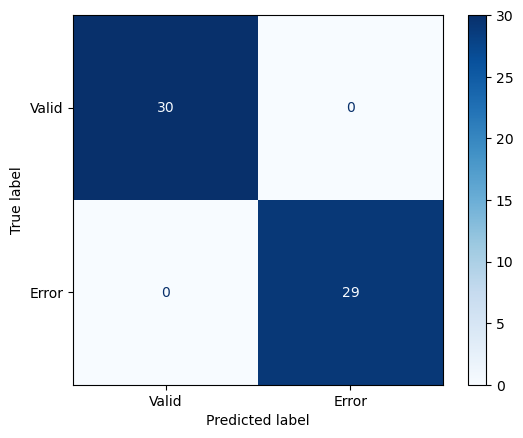

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Run batch prediction
y_pred_proba = predictor.predict(X_test.to_csv(header=False, index=False))['predictions']
y_pred = [int(float(p['score']) > 0.5) for p in y_pred_proba]

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Valid", "Error"])
disp.plot(cmap="Blues")

# Cleanup

This section deletes the deployed endpoint to avoid incurring charges.


In [8]:
predictor.delete_endpoint()

[04/04/25 17:19:17] INFO     Deleting endpoint configuration with name:                             ]8;id=947629;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=796670;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py#4995\4995]8;;\
                             sagemaker-xgboost-2025-04-04-17-15-13-901                                             

                    INFO     Deleting endpoint with name: sagemaker-xgboost-2025-04-04-17-15-13-901 ]8;id=99430;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=866305;file:///home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sagemaker/session.py#4985\4985]8;;\